Data acquisition

In [2]:
import sys
sys.path.append('/home/ppiper/github/frog')

from frog.datahandler import HDF5Handler, sliceDataAlongAxis
import numpy as np


In [3]:
lfdh = HDF5Handler(
    datapath = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/Q1D_transposed.hdf5', 
    datasets = ['p.txt', 'T.txt', 'M.txt']
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/Q1D_transposed.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
hfdh = HDF5Handler(
    datapath='/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/SU2_fluid_transposed.hdf5',
    datasets = ['Pressure', 'Temperature', 'Mach', 'Heat_Flux'],
)

In [8]:
lf_train, lf_validation, lf_test = sliceDataAlongAxis(lfdh[:], [0.8, 0.1, 0.1], axis=0)

hf_train, hf_validation, hf_test = sliceDataAlongAxis(hfdh[:], [0.8, 0.1, 0.1], axis=0)

Oder reduction

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from frog.neuralnetwork import get_model

from frog.normalization import Normalization, DataHandlerNormalization

X_rom = Pipeline([
    #('scaler', StandardScaler()),
    ('scaler', Normalization(bounds=[0,1])),
    #('scaler', DataHandlerNormalization(datahandler=lfdh, bounds=[0,1])),
    #('scaler', RobustScaler()),
    ('pca', PCA(n_components=5)),
])


y_rom = Pipeline([
    #('scaler', StandardScaler()),
    ('scaler', Normalization(bounds=[0,1])),
    #('scaler', DataHandlerNormalization(datahandler=hfdh, bounds=[0,1])),
    #('scaler', RobustScaler()),
    ('pca', PCA(n_components=5)),
])


surrogate_linear = Pipeline([
    ('regression', LinearRegression())
])

surrogate_kriging = Pipeline([
    ('regression', GaussianProcessRegressor())
])

#surrogate = Pipeline([
#    ('regression', MLPRegressor(hidden_layer_sizes=(5,5,5), max_iter=1000))
#])

#from frog.neuralnetwork import get_model

#surrogate = Pipeline([
#    ('regression', get_model(5,5,5,10))
#])




surrogate = get_model(5,5,1,5)

In [10]:
from frog.flow_reconstruction import FR

fr = FR(X_rom, y_rom, surrogate)

In [11]:
fr.fit(
    lf_train, 
    hf_train, 
    fit_kwargs = dict( 
        epochs= 500, 
        batch_size= 16, 
        validation_data=(lf_validation, hf_validation)
    )
)

Performing ROM fit on X data
Performing ROM fit on y data
Performing ROM fit on X validation data
Performing ROM fit on y validation data
Performing surrogate model fit
Epoch 1/500
10/10 [==============================] - 3s 80ms/step - loss: 0.3984 - val_loss: 0.4670
Epoch 2/500
10/10 [==============================] - 0s 17ms/step - loss: 0.3970 - val_loss: 0.4657
Epoch 3/500
10/10 [==============================] - 0s 19ms/step - loss: 0.3958 - val_loss: 0.4645
Epoch 4/500
10/10 [==============================] - 0s 18ms/step - loss: 0.3947 - val_loss: 0.4631
Epoch 5/500
10/10 [==============================] - 0s 12ms/step - loss: 0.3935 - val_loss: 0.4617
Epoch 6/500
10/10 [==============================] - 0s 17ms/step - loss: 0.3920 - val_loss: 0.4602
Epoch 7/500
10/10 [==============================] - 0s 17ms/step - loss: 0.3905 - val_loss: 0.4585
Epoch 8/500
10/10 [==============================] - 0s 14ms/step - loss: 0.3892 - val_loss: 0.4569
Epoch 9/500
10/10 [============

In [42]:

import matplotlib.pyplot as plt

def plot_results(hfdh, fr, lf_test, hf_test, idx=None, ax=None, ylim=None, subplots_kwarg={}):
    if ax is None and subplots_kwarg == {}:
        fig, ax = plt.subplots()
    elif subplots_kwarg != {}:
        fig, ax = plt.subplots(**subplots_kwarg)
        ax = ax.flatten()
    
        for i in range(len(ax)):
            plot_results(hfdh, fr, lf_test, hf_test, i, ax=ax[i], ylim=ylim)
    else:
        ax.plot(hfdh(hf_test)[idx,'Heat_Flux'][1:-1])
        ax.plot(hfdh(fr.predict(lf_test))[idx,'Heat_Flux'][1:-1], ls='-.')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.legend()

In [74]:

min_all = np.min(hfdh(hf_test)['Heat_Flux'][1:-1])
max_all = np.max(hfdh(hf_test)['Heat_Flux'][1:-1])
min_all, max_all

(74120.9, 1883554.0)

1/1 [==============================] - 0s 50ms/step
inverse_transform
1/1 [==============================] - 0s 64ms/step
inverse_transform
1/1 [==============================] - 0s 57ms/step
inverse_transform
1/1 [==============================] - 0s 48ms/step
inverse_transform
1/1 [==============================] - 0s 68ms/step
inverse_transform
1/1 [==============================] - 0s 56ms/step
inverse_transform
1/1 [==============================] - 0s 63ms/step
inverse_transform
1/1 [==============================] - 0s 44ms/step
inverse_transform
1/1 [==============================] - 0s 51ms/step
inverse_transform
1/1 [==============================] - 0s 56ms/step
inverse_transform
1/1 [==============================] - 0s 48ms/step
inverse_transform
1/1 [==============================] - 0s 48ms/step
inverse_transform
1/1 [==============================] - 0s 66ms/step
inverse_transform
1/1 [==============================] - 0s 56ms/step
inverse_transform
1/1 [===============

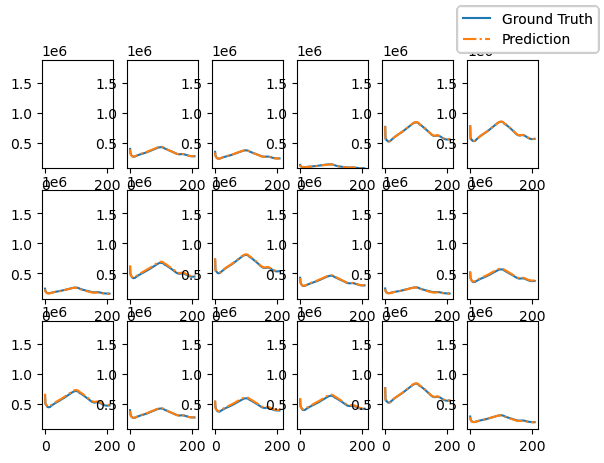

In [79]:


def plot_prediction(
        plot_data = [],
        ax=None,
        xlabel='',
        ylabel='',
        title='',
        xlim=None,
        ylim=None,):
    if ax is None:
        fig, ax = plt.subplots()
    for data, kwargs in plot_data:
        ax.plot(*data, **kwargs)
    #ax.plot(ground_truth, **ground_truth_kwargs)
    #ax.plot(prediction, **prediction_kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    #ax.legend()

fig,ax = plt.subplots(3,6)
ax = ax.flatten()

min_all = np.min(hfdh(hf_test)['Heat_Flux'][1:-1])
max_all = np.max(hfdh(hf_test)['Heat_Flux'][1:-1])

for i in range(len(ax)):
    ground_truth = hfdh(hf_test)[i,'Heat_Flux'][1:-1]
    prediction = hfdh(fr.predict(lf_test))[i,'Heat_Flux'][1:-1]

    plot_prediction(
        plot_data=[
            ((ground_truth,), dict(label='Ground Truth')), 
            ((prediction,), dict(label='Prediction', ls='-.'))],
        ax = ax[i],
        ylim = [min_all, max_all],
    )

    lines_labels = [axi.get_legend_handles_labels() for axi in ax[0:1]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)

here
here else
1/1 [==============================] - 0s 59ms/step


inverse_transform
here else
1/1 [==============================] - 0s 49ms/step


inverse_transform
here else
1/1 [==============================] - 0s 60ms/step


inverse_transform
here else
1/1 [==============================] - 0s 57ms/step


inverse_transform
here else
1/1 [==============================] - 0s 64ms/step


inverse_transform
here else
1/1 [==============================] - 0s 60ms/step


inverse_transform
here else
1/1 [==============================] - 0s 52ms/step


inverse_transform
here else
1/1 [==============================] - 0s 67ms/step


inverse_transform
here else
1/1 [==============================] - 0s 55ms/step


inverse_transform
here else
1/1 [==============================] - 0s 52ms/step


inverse_transform
here else
1/1 [==============================] - 0s 78ms/step


inverse_transform
here else
1/1 [==============================] - 0s 59ms/step


inverse_transform
here else
1/1 [==============================] - 0s 52ms/step


inverse_transform
here else
1/1 [==============================] - 0s 63ms/step


inverse_transform
here else
1/1 [==============================] - 0s 80ms/step
inverse_transform


here else
1/1 [==============================] - 0s 60ms/step


inverse_transform
here else
1/1 [==============================] - 0s 52ms/step


inverse_transform
here else
1/1 [==============================] - 0s 51ms/step


inverse_transform


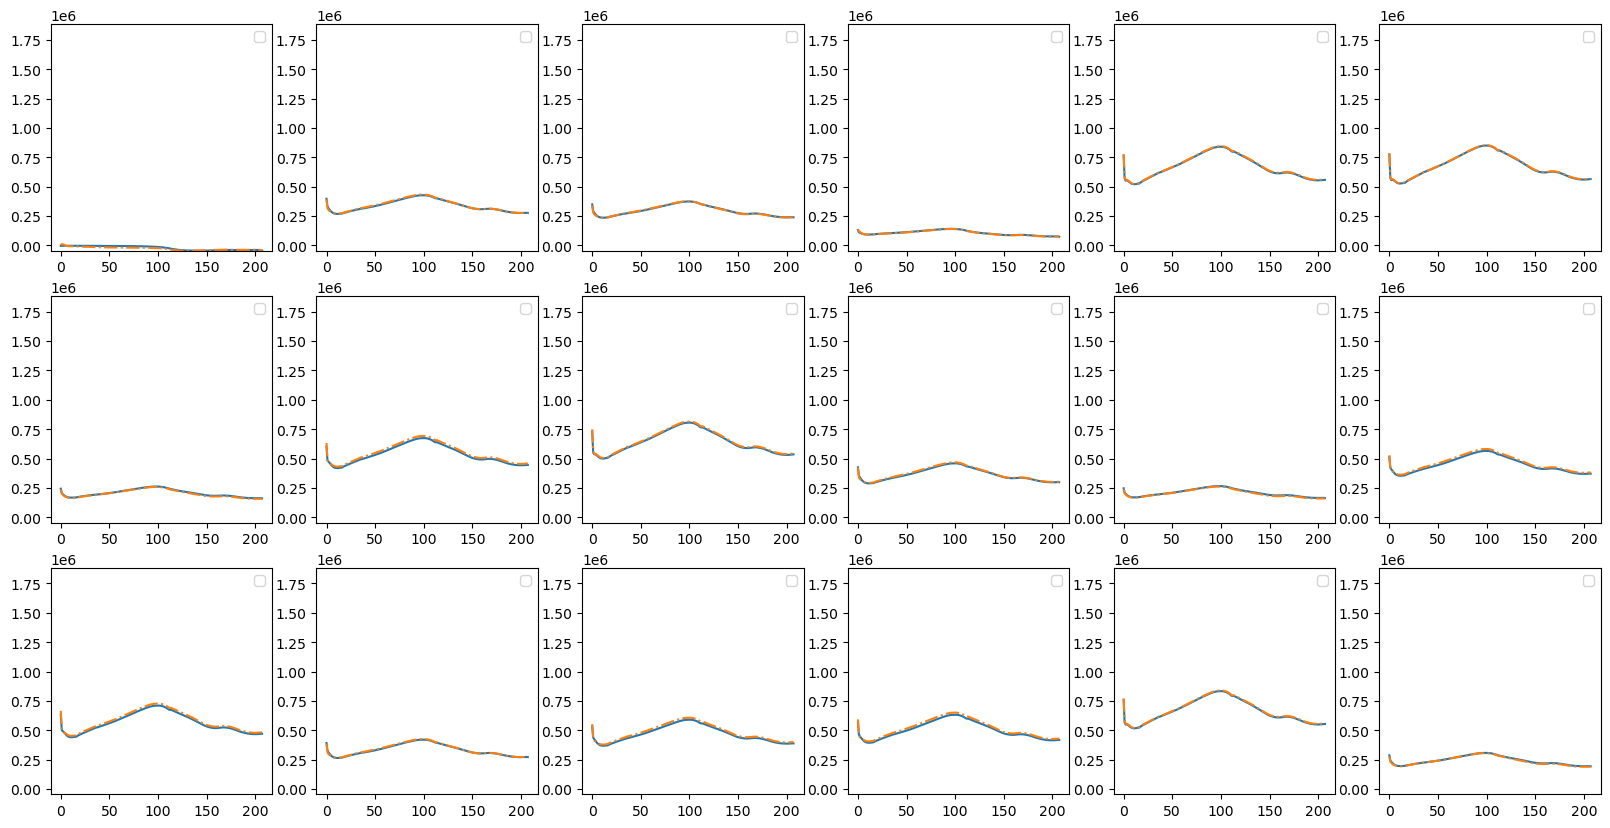

In [43]:
plot_results(hfdh, fr, lf_test, hf_test, ylim=[vmin, vmax], subplots_kwarg=dict(nrows=3, ncols=6, figsize=(20,10)))

1/1 [==============================] - 1s 606ms/step
inverse_transform


1/1 [==============================] - 0s 59ms/step


inverse_transform
1/1 [==============================] - 0s 53ms/step
inverse_transform


1/1 [==============================] - 0s 42ms/step
inverse_transform


1/1 [==============================] - 0s 48ms/step


inverse_transform
1/1 [==============================] - 0s 68ms/step
inverse_transform


1/1 [==============================] - 0s 59ms/step


inverse_transform
1/1 [==============================] - 0s 52ms/step
inverse_transform


1/1 [==============================] - 0s 46ms/step
inverse_transform


1/1 [==============================] - 0s 47ms/step


inverse_transform
1/1 [==============================] - 0s 65ms/step


inverse_transform
1/1 [==============================] - 0s 49ms/step


inverse_transform
1/1 [==============================] - 0s 54ms/step


inverse_transform
1/1 [==============================] - 0s 58ms/step


inverse_transform
1/1 [==============================] - 0s 48ms/step


inverse_transform
1/1 [==============================] - 0s 71ms/step


inverse_transform
1/1 [==============================] - 0s 57ms/step


inverse_transform
1/1 [==============================] - 0s 60ms/step


inverse_transform


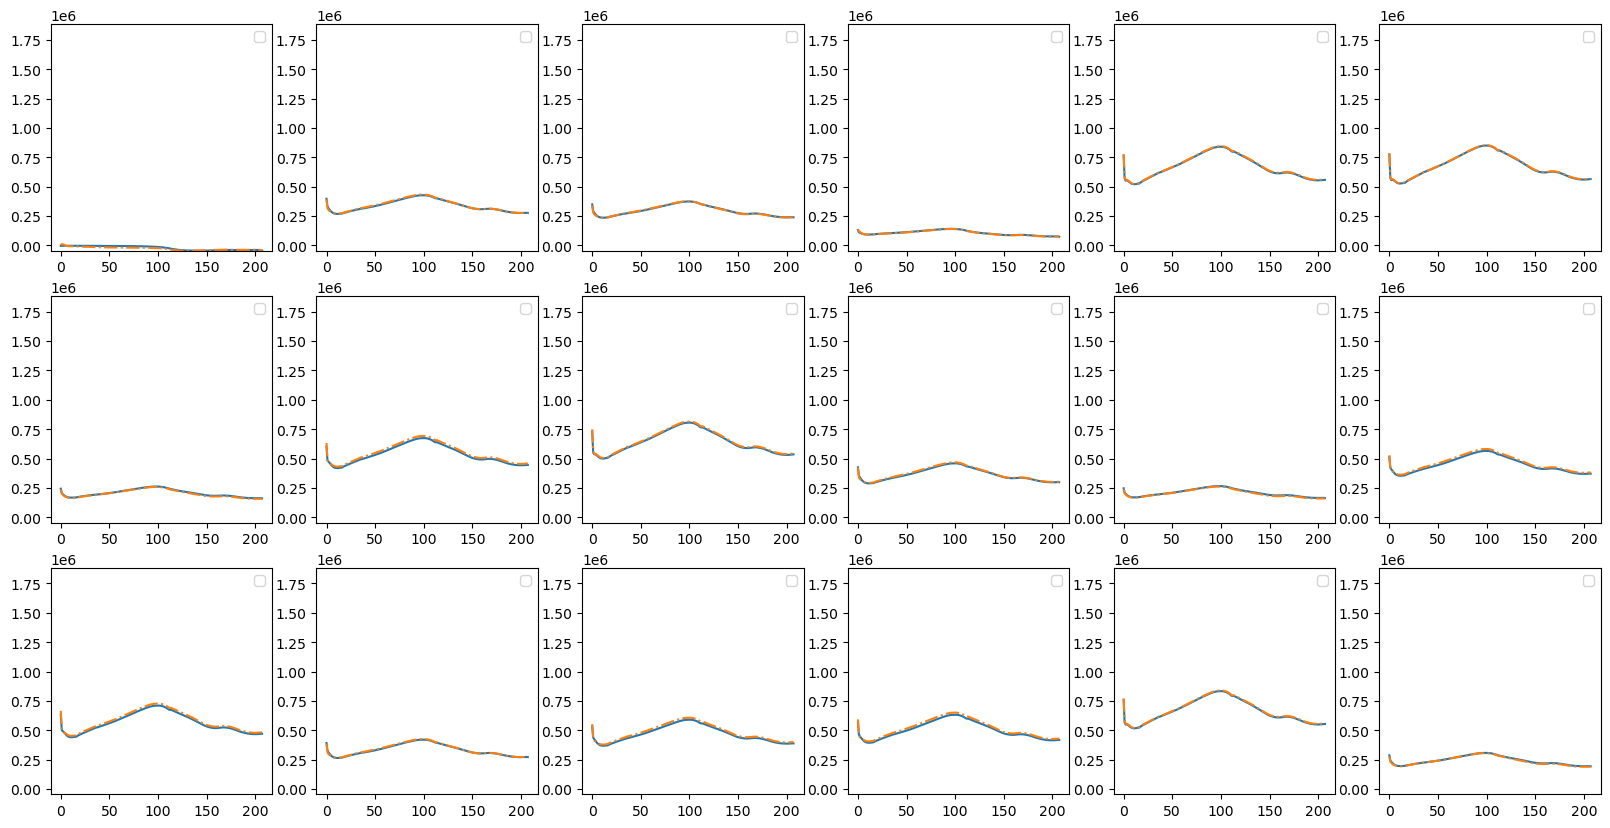

In [24]:


fig, ax = plt.subplots(3,6, figsize=(20,10))
ax = ax.flatten()

vmin = np.min(hfdh(hf_test)[:,'Heat_Flux'])
vmax = np.max(hfdh(hf_test)[:,'Heat_Flux'])

for i in range(18):
    plot_results(hfdh, fr, lf_test, hf_test, i, ax[i], ylim=[vmin, vmax])

Performing ROM fit on X data
Performing ROM fit on y data
Performing surrogate model fit
1/1 [==============================] - 0s 19ms/step


inverse_transform
1/1 [==============================] - 0s 64ms/step


inverse_transform
1/1 [==============================] - 0s 38ms/step


inverse_transform
1/1 [==============================] - 0s 38ms/step


inverse_transform
1/1 [==============================] - 0s 40ms/step


inverse_transform
1/1 [==============================] - 0s 23ms/step


inverse_transform
1/1 [==============================] - 0s 40ms/step


inverse_transform
1/1 [==============================] - 0s 35ms/step


inverse_transform
1/1 [==============================] - 0s 46ms/step


inverse_transform
1/1 [==============================] - 0s 53ms/step


inverse_transform
1/1 [==============================] - 0s 38ms/step


inverse_transform
1/1 [==============================] - 0s 37ms/step


inverse_transform
1/1 [==============================] - 0s 47ms/step


inverse_transform
1/1 [==============================] - 0s 37ms/step
inverse_transform


1/1 [==============================] - 0s 35ms/step


inverse_transform
1/1 [==============================] - 0s 27ms/step


inverse_transform
1/1 [==============================] - 0s 40ms/step


inverse_transform
1/1 [==============================] - 0s 50ms/step


inverse_transform


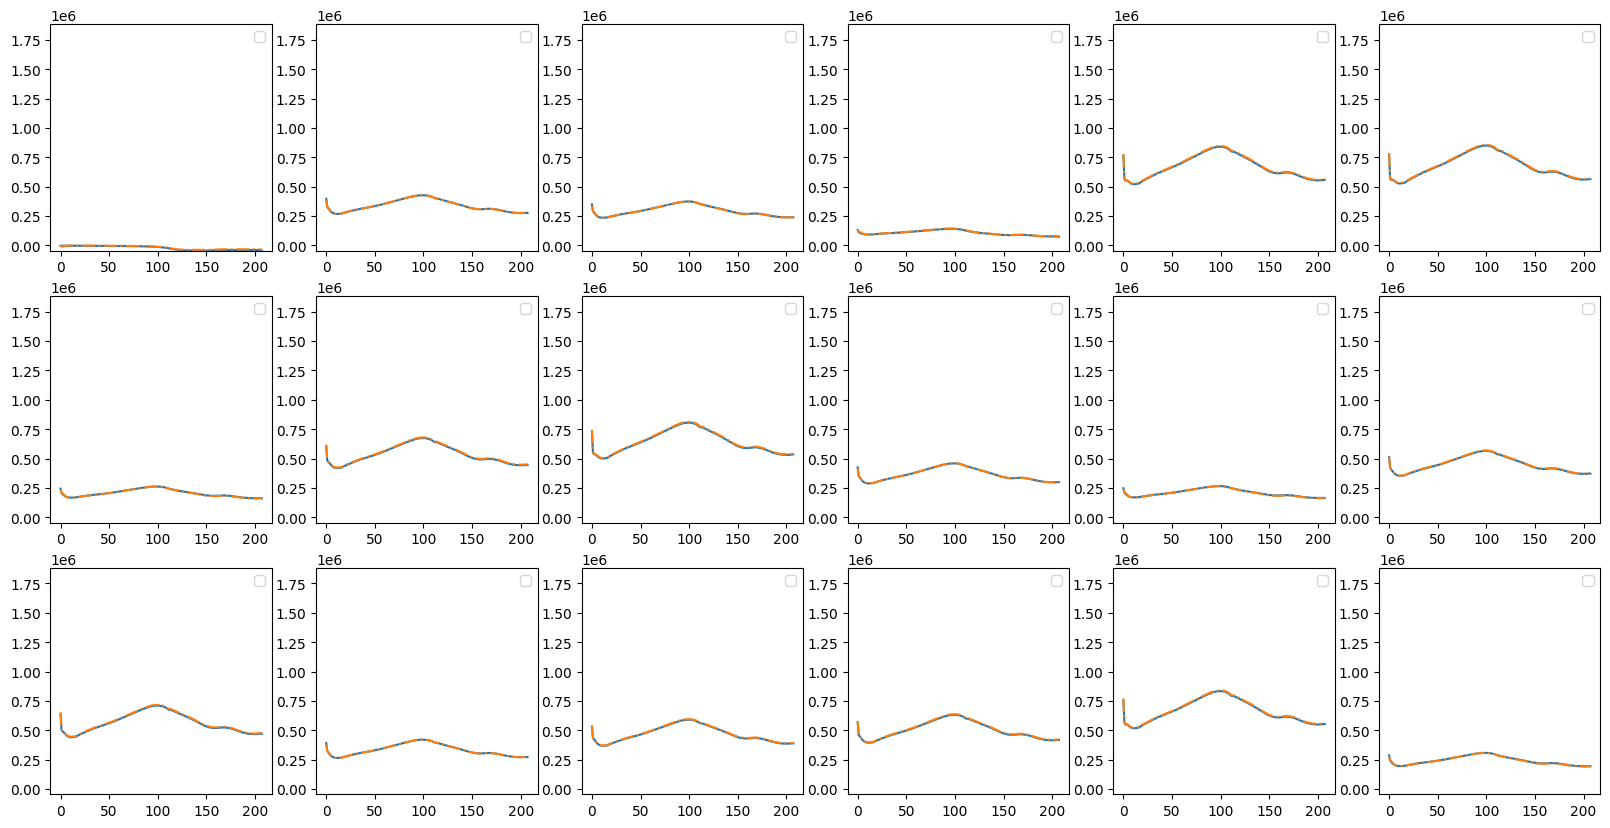

In [43]:
fr_linear = FR(X_rom, y_rom, surrogate_linear)
fr_linear.fit(
    lf_train, 
    hf_train, 
)


fig, ax = plt.subplots(3,6, figsize=(20,10))
ax = ax.flatten()

vmin = np.min(hfdh(hf_test)[:,'Heat_Flux'])
vmax = np.max(hfdh(hf_test)[:,'Heat_Flux'])

for i in range(18):
    plot_results(hfdh, fr, lf_test, hf_test, i, ax[i], ylim=[vmin, vmax])


In [35]:
fr_kriging = FR(X_rom, y_rom, surrogate_kriging)
fr_kriging.fit(
    lf_train, 
    hf_train, 
)


Performing ROM fit on X data
Performing ROM fit on y data
Performing surrogate model fit


1/1 [==============================] - 0s 24ms/step


inverse_transform
1/1 [==============================] - 0s 57ms/step


inverse_transform
1/1 [==============================] - 0s 36ms/step
inverse_transform


1/1 [==============================] - 0s 27ms/step


inverse_transform
1/1 [==============================] - 0s 45ms/step


inverse_transform
1/1 [==============================] - 0s 33ms/step


inverse_transform
1/1 [==============================] - 0s 42ms/step


inverse_transform
1/1 [==============================] - 0s 34ms/step


inverse_transform
1/1 [==============================] - 0s 34ms/step
inverse_transform


1/1 [==============================] - 0s 28ms/step


inverse_transform
1/1 [==============================] - 0s 34ms/step
inverse_transform


1/1 [==============================] - 0s 36ms/step
inverse_transform


1/1 [==============================] - 0s 45ms/step
inverse_transform


1/1 [==============================] - 0s 30ms/step


inverse_transform
1/1 [==============================] - 0s 35ms/step


inverse_transform
1/1 [==============================] - 0s 33ms/step


inverse_transform
1/1 [==============================] - 0s 45ms/step


inverse_transform
1/1 [==============================] - 0s 38ms/step


inverse_transform


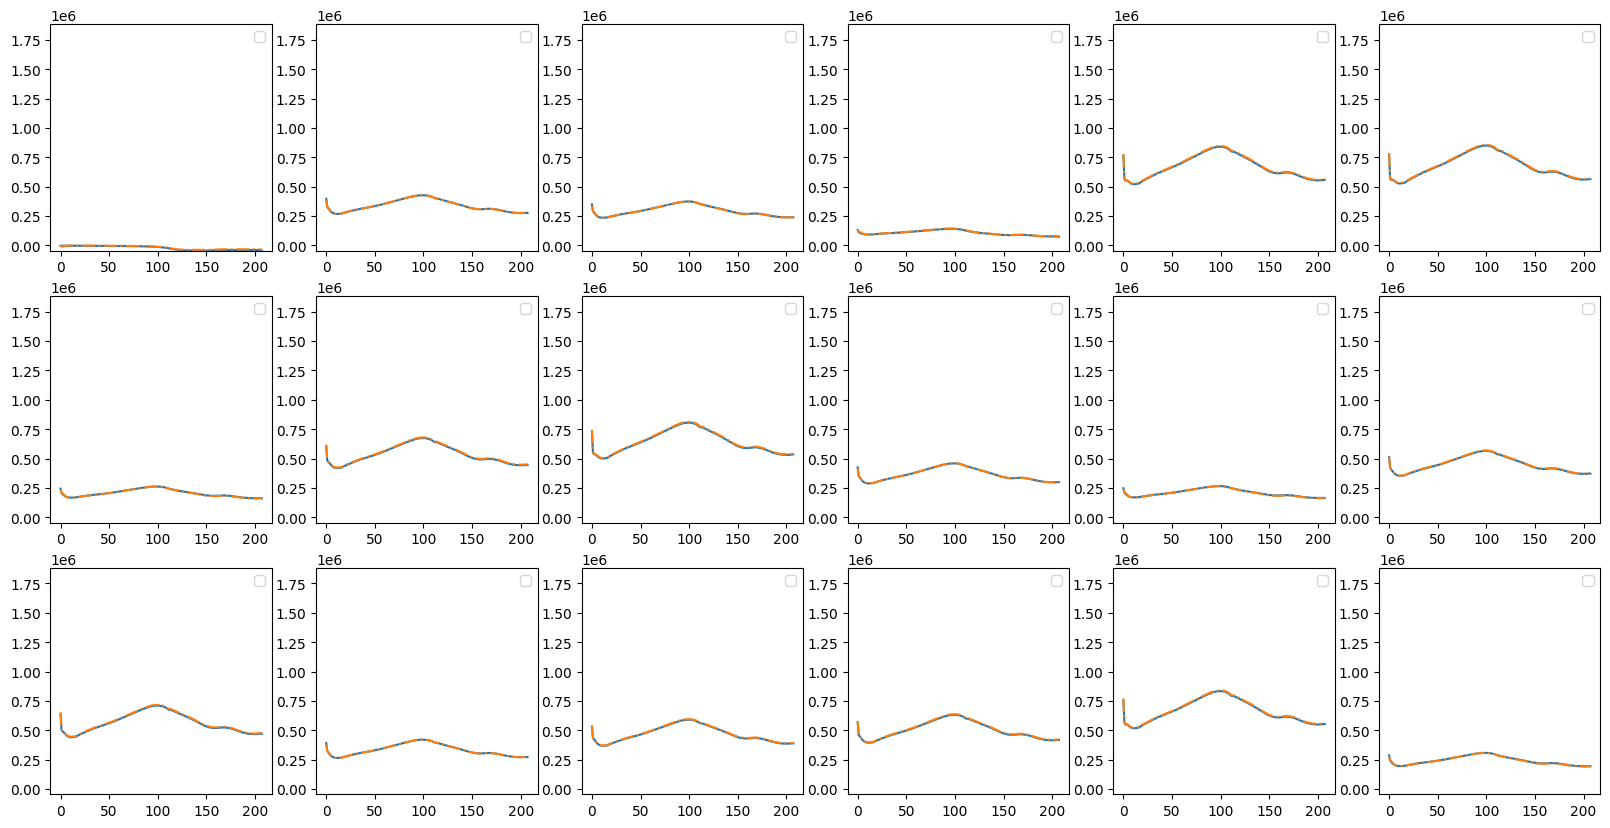

In [44]:
fig, ax = plt.subplots(3,6, figsize=(20,10))
ax = ax.flatten()

vmin = np.min(hfdh(hf_test)[:,'Heat_Flux'])
vmax = np.max(hfdh(hf_test)[:,'Heat_Flux'])

for i in range(18):
    plot_results(hfdh, fr, lf_test, hf_test, i, ax[i], ylim=[vmin, vmax])

In [21]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bypass', None)])

In [22]:
pipe.fit_transform(lf_train).shape

(145, 633)

In [50]:
fr_kriging
fr_linear
fr

NameError: name 'fr_kriging' is not defined